# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
# http://pytorch.org/
from os.path import exists
#!pip install numpy==1.15.0
!pip install -q install wheel==0.34.2 setuptools

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
print(get_abbr_impl())
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#https://download.pytorch.org/whl/cpu/torch-0.4.1.post2-cp37-cp37m-linux_x86_64.whl
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1.post2-{platform}-linux_x86_64.whl torchvision==0.2.1
import torch

cp
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -q http://download.pytorch.org/whl/	libcudart.so.12 (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libcudart.so.12/torch-0.4.1.post2-cp310-cp310-linux_x86_64.whl torchvision==0.2.1'


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Receiving objects: 100% (10/10), 11.01 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [48]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [49]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

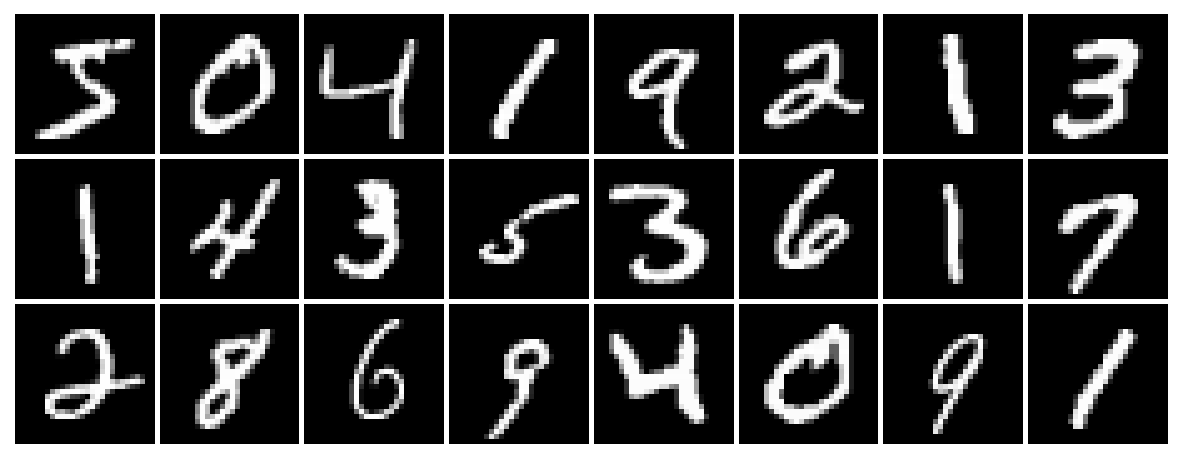

In [50]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


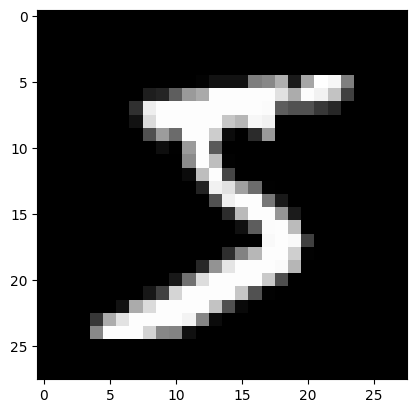

In [51]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [52]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [53]:
pred = model(x_train[:5].view(-1, 28*28))
pred

tensor([[-0.2287, -0.0692, -0.1408,  0.0477, -0.0349,  0.3081, -0.2326, -0.1029,
         -0.0508,  0.3224],
        [-0.1260, -0.0976, -0.1888, -0.4188, -0.1684,  0.1020, -0.4948, -0.4130,
         -0.4018,  0.2066],
        [ 0.1555, -0.0825, -0.1126,  0.0467,  0.1512, -0.1865,  0.0140, -0.0684,
          0.1544,  0.1963],
        [-0.0083, -0.1452,  0.0059, -0.0147, -0.1320,  0.2845, -0.1071,  0.0999,
         -0.1652, -0.1108],
        [ 0.2020, -0.0262,  0.0071, -0.1611, -0.2348,  0.0877, -0.1249, -0.2671,
         -0.0194, -0.0767]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [54]:
epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [13]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-9lqf7rg_
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-9lqf7rg_
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.10

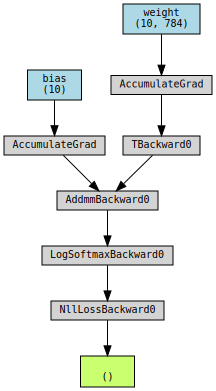

In [14]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

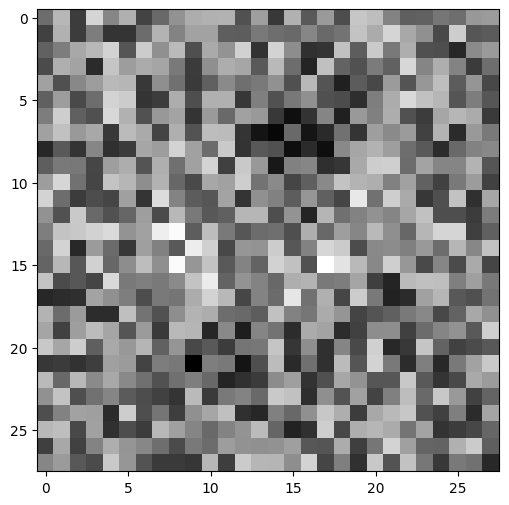

Época: 1
Perda: 2.3207952976226807
Accuracy: 0.073




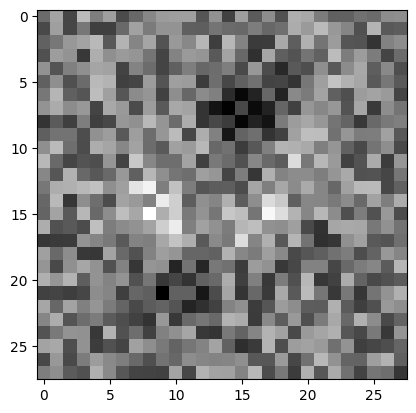

Época: 2
Perda: 1.8117033243179321
Accuracy: 0.655




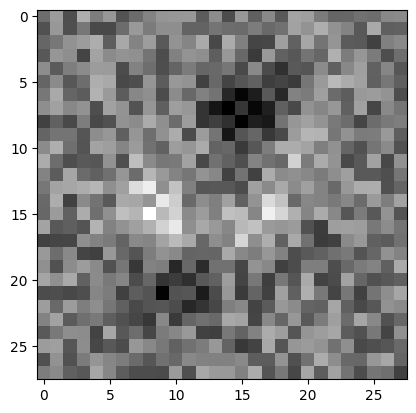

Época: 3
Perda: 1.4692274332046509
Accuracy: 0.771




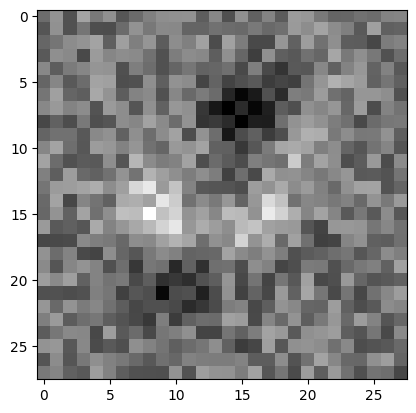

Época: 4
Perda: 1.2483913898468018
Accuracy: 0.769




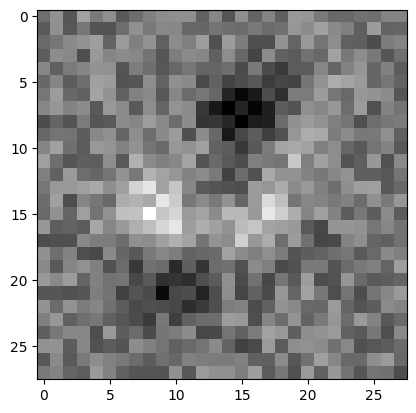

Época: 5
Perda: 1.0980589389801025
Accuracy: 0.814




In [55]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        plt.imshow(model.weight.data[4].numpy().reshape((28,28)),cmap = 'gray')
        plt.show()

        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        print("Época: " + str(i + 1))
        print("Perda: " + str(loss.item()))
        print('Accuracy:', accuracy)
        print("\n")
except KeyboardInterrupt:
    pass

In [56]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [57]:
print('Final loss:', loss.item())

Final loss: 1.0980589389801025


### Visualizando gráfico de perda durante o treinamento

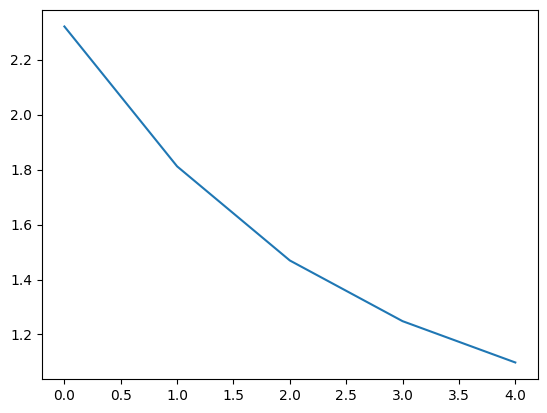

In [58]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [59]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.815


### Matriz de confusão com dados de treinamento e teste

In [60]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,94,0,3,1,0,9,2,2,0,3
1,0,110,11,1,1,4,2,7,7,2
2,1,0,74,1,1,2,1,1,2,0
3,0,1,2,80,0,17,1,0,9,2
4,0,0,0,0,91,4,3,3,0,7
5,0,1,0,0,0,47,0,0,1,1
6,2,1,2,2,4,3,84,0,1,1
7,0,1,5,3,1,1,0,100,0,12
8,0,2,2,2,1,3,1,0,64,1


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


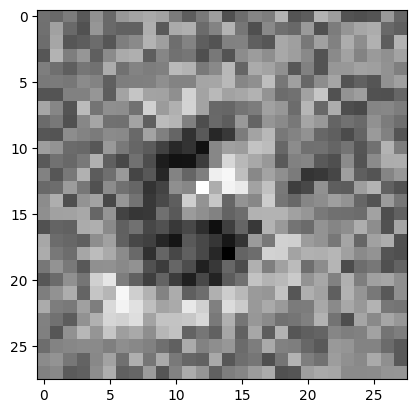

In [61]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

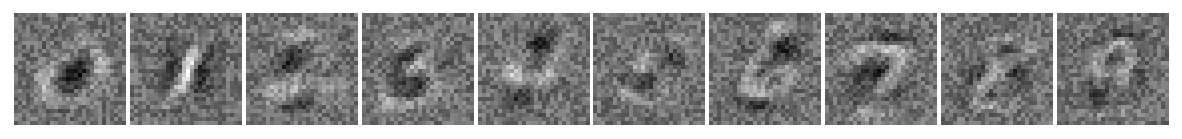

In [62]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](http://casadei.io/images/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

     R. Feito no código acima.

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

  R. Feito no código acima.

## Perguntas

1. Qual é o shape da matriz de entrada na rede? R. (6000, 28, 28)
2. Qual é o shape da saída da rede? (6000, 10)
3. Qual é o número total de parâmetros da rede, incluindo o bias? R. 7850 parâmetros (28 * 28 * 10 + 10)

# Aprendizados
